In [69]:
import pandas as pd
import seaborn as sns

In [110]:
samples = pd.read_csv('samples_value_order.csv', index_col=0, header=[0,1])
# samples.columns.name = 'domain'
# samples = samples.stack().to_frame('value')
samples = samples.stack([0, 1]).to_frame('value')

samples.index.names = ['sample', 'domain', 'order']

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_36868/1514250061.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  samples = samples.stack([0, 1]).to_frame('value')


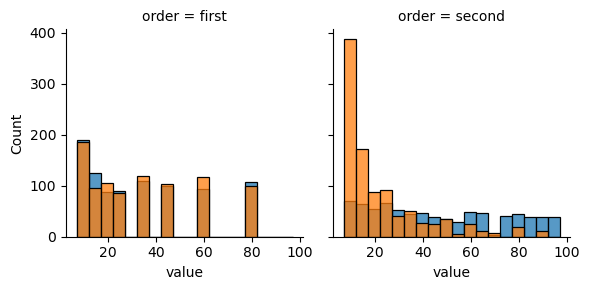

In [121]:
g = sns.FacetGrid(samples.reset_index(), col='order', hue='domain', sharex=False)

g.map(sns.histplot, 'value', bins=np.arange(7, 100, 5), kde=False, common_norm=False)

# log sapce x-axis
# g.set(xscale='log')


# Load data

In [145]:
from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_prediction, stimulation_order, stimulation_palette
import seaborn as sns
import arviz as az
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np
import numpy as np
from bauer.models import FlexibleNoiseRiskRegressionModel
from tqdm import tqdm

bids_folder = '/data/ds-tmsrisk'

# Some convenience functions
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):

    df = get_data(model_label=model_label, bids_folder=bids_folder)
    model = build_model(df=df, model_label=model_label)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

    return df, model, idata

conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

curve_stats = []
model_label  = 'flexible1'

df, model, idata = get_info(model_label)
model.build_estimation_model()
curves = model.get_sd_curve(conditions, idata=idata, x=np.arange(7, 108), variable='both', group=True)
curve_stats = FlexibleNoiseRiskRegressionModel.get_sd_curve_stats(curves.stack().to_frame('value'), groupby=['stimulation_condition'])


In [146]:
import seaborn as sns
import scipy.stats as ss

In [147]:
curve_stats = curve_stats.xs('vertex', 0, 'stimulation_condition')

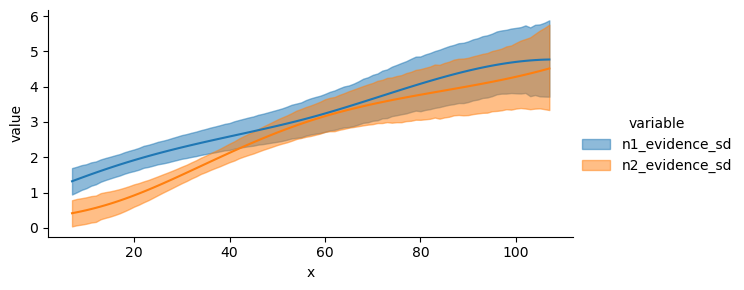

In [148]:
def plot_prediction(data, x='x', y='value', **kwargs):
    ax = sns.lineplot(data=data, x=x, y=y, **kwargs)
    plt.fill_between(data[x], data['hdi025'], data['hdi975'], alpha=0.5, **kwargs)
    return ax
g = sns.FacetGrid(curve_stats.reset_index(), hue='variable', height=3, aspect=2, )

g.map_dataframe(plot_prediction)
g.add_legend()

In [149]:
df = []
for (i, domain, order), row in samples.iterrows():
    # for variable in ['n1_evidence_sd', 'n2_evidence_sd']:

    variable = 'n1_evidence_sd' if order == 'first' else 'n2_evidence_sd'
    dist = ss.norm(row.value, curve_stats.loc[(int(row.value), variable), 'value'])
    df.append(pd.DataFrame({'ix':i, 'domain': domain, 'value': dist.rvs(500), 'variable': variable, 'generating_value':row.value}))

df = pd.concat(df) 

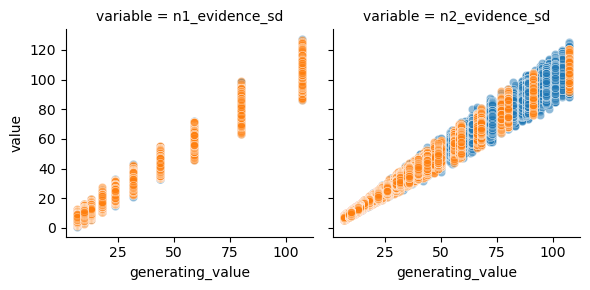

In [150]:
g = sns.FacetGrid(df, col='variable', hue='domain', sharex=False)

g.map(sns.scatterplot, 'generating_value', 'value', alpha=0.5)


# sns.scatterplot(x='generating_value', y='value', hue='domain', data=df.iloc[::100], alpha=0.5)

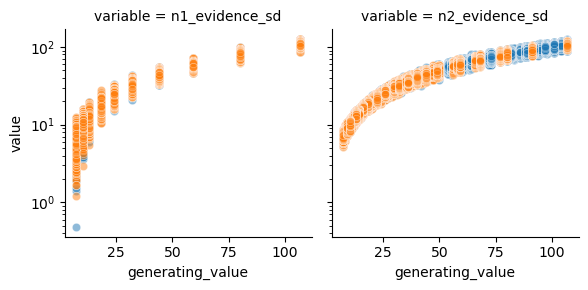

In [151]:
g = sns.FacetGrid(df, col='variable', hue='domain', sharex=False)

g.map(sns.scatterplot, 'generating_value', 'value', alpha=0.5)


g.set(yscale='log')

# sns.scatterplot(x='generating_value', y='value', hue='domain', data=df.iloc[::100], alpha=0.5)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_36868/2662358924.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  log_sd = df.groupby(['domain', 'generating_value', 'variable', 'ix']).apply(lambda d: np.std(np.log(d.value))).to_frame('log_sd')


(0.0, 0.20952078781267838)

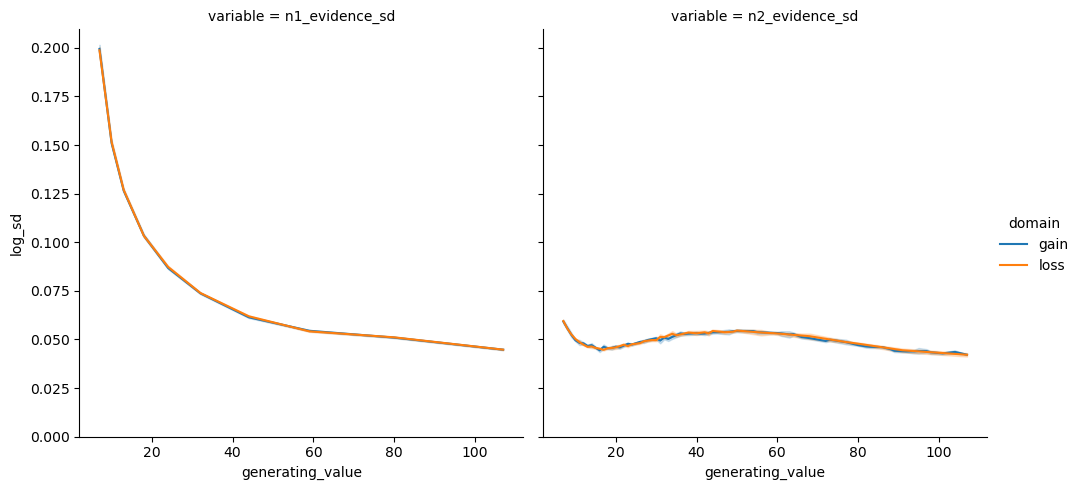

In [152]:
log_sd = df.groupby(['domain', 'generating_value', 'variable', 'ix']).apply(lambda d: np.std(np.log(d.value))).to_frame('log_sd')


sns.relplot(x='generating_value', y='log_sd', hue='domain', col='variable', data=log_sd.reset_index(), kind='line')

plt.ylim(0, None)

In [153]:
log_sd.groupby(['variable', 'domain']).mean()

log_sd
variable       domain          
n1_evidence_sd gain    0.094317
               loss    0.093310
n2_evidence_sd gain    0.048118
               loss    0.051036

<Axes: xlabel='value', ylabel='Count'>

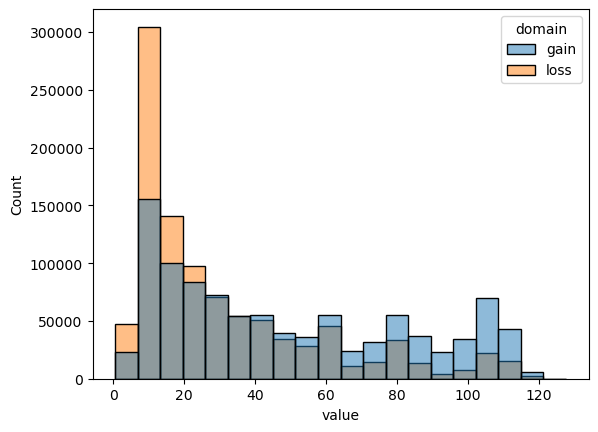

In [154]:
sns.histplot(df, x='value', hue='domain', bins=20, kde=False, common_norm=False)

In [ ]:
n1 = [7, 10, 13, 18, 24, 32, 44, 59,  ]

In [95]:
samples.groupby(['value']).size().sort_values()[::-1].iloc[:25]

value
7.0      198
107.0    178
10.0     156
18.0     139
13.0     138
24.0     132
44.0     115
32.0     111
80.0     111
59.0     110
9.0       44
8.0       30
15.0      25
11.0      22
50.0      18
34.0      17
26.0      17
101.0     16
21.0      16
14.0      16
30.0      15
12.0      14
66.0      13
19.0      13
16.0      13
dtype: int64

In [21]:
curve_stats.xs('vertex', 0, 'stimulation_condition')

value    hdi025    hdi975
x   variable                                    
7   n1_evidence_sd  1.321015  0.946074  1.693755
    n2_evidence_sd  0.415799  0.042080  0.782646
8   n1_evidence_sd  1.371275  1.008443  1.731716
    n2_evidence_sd  0.442188  0.073620  0.819517
9   n1_evidence_sd  1.421013  1.076124  1.776869
...                      ...       ...       ...
105 n2_evidence_sd  4.441920  3.384605  5.586642
106 n1_evidence_sd  4.765213  3.719121  5.811365
    n2_evidence_sd  4.477839  3.362431  5.663358
107 n1_evidence_sd  4.768592  3.716048  5.878611
    n2_evidence_sd  4.514977  3.337727  5.755739

[202 rows x 3 columns]

In [15]:
curve_stats

value    hdi025    hdi975
x  variable       stimulation_condition                              
7  n1_evidence_sd ips                    1.182852  0.834564  1.519961
                  vertex                 1.321015  0.946074  1.693755
   n2_evidence_sd ips                    0.816973  0.336821  1.277041
                  vertex                 0.415799  0.042080  0.782646
8  n1_evidence_sd ips                    1.255569  0.932804  1.600720
...                                           ...       ...       ...
98 n2_evidence_sd vertex                 4.245037  3.346909  5.151286
99 n1_evidence_sd ips                    4.326080  3.588118  5.094776
                  vertex                 4.687939  3.794608  5.636778
   n2_evidence_sd ips                    4.221419  3.476556  4.958208
                  vertex                 4.273182  3.381860  5.230498

[372 rows x 3 columns]